# Modelado de Topicos en Especificaciones de API's REST con LDA usando NLTK y SKLearn

Este trabajo se propone identificar topicos presentes en la descripcion de las API's REST disponibles en el repositorio https://github.com/APIs-guru/openapi-directory/tree/master/APIs con el objetivo de detectar información referida a prácticas de despligue y aspectos no funcionales de una apliacación. En particular, el enfoque se basa en el modelado de tópicos utilizando el modelo Latent Dirichlet Allocation (LDA), un modelo probabilístico generativo de tópicos. 

El repositorio analizado está formado por 326 aplicaciones (adobe, instagram, amazon, github, entre otras) que contienen 1418 archivos "swagger.yaml" y "openapi.yaml" y, de estos últimos, 1026 (72,35\%) contienen las propiedades "description" y "summary" que fueron usadas para formar los documentos.

El flujo de trabajo propuesto para la detección de los tópicos consta de cuatro etapas: I) Generación del corpus, II) Pre-procesamiento, III) Construcción del modelo, y IV) Identificación de tópicos. La implementación se llevó a cabo con los paquetes NLTK y SKLearn de Python.

**I)- Generación del Corpus:** El primer paso fue crear el corpus de referencia a partir de las especificaciones de APIs del repositorio en estudio. El proceso consistió en recorrer el repositorio y, para cada uno de los archivos swagger y openapi que se encuentran en los distintos directorios de las aplicaciones, generar un documento con la información presente en los tags "description" y "summary" (para cada operación http del path correspondiente). Finalmente, se obtuvo un corpus con un total de 1026 documentos. 

In [4]:
import sys
import os
import yaml

data_list=[]

for base, dirs, files in os.walk('E:/ISISTAN/Cursos/Mineria de datos/Trabajo topicos/openapi-directory-master/APIs-original'):
    for f in files:
        text_document = ''
        if f == "swagger.yaml" or f == "openapi.yaml":
            data = yaml.safe_load(open(os.path.join(base,f), encoding="utf8"))
            try:
                if 'description' in list(data['info'].keys()):
                    text_document = str(data['info']['description']) + ' '
                    #data_list.append(data['info']['description'])
                    #print(data['info']['description'])
                    
                for api in data['paths'].keys():
                    for methodHTTP in data['paths'][api].keys():
                        #print(data['paths'][api][methodHTTP].keys())
                        if 'summary' in list(data['paths'][api][methodHTTP].keys()):
                            text_document = text_document + str(data['paths'][api][methodHTTP]['summary']) + ' '
                            #print(data['paths'][api][methodHTTP]['summary'])
                            #data_list.append(data['paths'][api][methodHTTP]['summary'])
               
                text_document = text_document[0:len(text_document)-1] #quita el ultimo espacio agregado al final d la cadena
                data_list.append(text_document)
            except (OSError, RuntimeError, TypeError, NameError, AttributeError):
                    pass
    
                
print ('NUMERO DE ELEMENTOS: ' + str(len(data_list)))
print(data_list[:2])

NUMERO DE ELEMENTOS: 1026
['Stock and Forex Data and Realtime Quotes Get quotes for all symbols Get a list of symbols for which we provide real-time quotes', 'Strong authentication, without the passwords.']


**II) Pre-procesamiento:** Para la etapa de pre-procesamiento se realizaron 4 actividades, a saber:

* Tokenización: a partir del corpus obtenido se generaron los tokens usando la biblioteca NLTK (Natural Language Toolkit) mediante la invocación al método word_tokenize().

In [14]:
import numpy as np
import re, nltk
#nltk.download('punkt')
from nltk import word_tokenize
from nltk.corpus import stopwords
from string import ascii_lowercase
import string

#TOKENIZACION CON NLTK
tokenized_data = []
for sentence in data_list:
    tokenized_data.append(word_tokenize(sentence.lower()))

* Filtro de stopwords: la eliminación de stopwords se realiza chequeando el contenido del documento contra un listado disponible. Por lo tanto, se construyó una lista de stopwords con NLTK considerando, además de las stopwords que proporciona la propia biblioteca (para el idioma inglés), una serie de palabras propias del contexto, tales como: api, rest, service, http, url, entre otras.

In [15]:
#ELIMINACION DE STOPWORDS
#nltk.download('stopwords')
stopwords = stopwords.words('english')
stopwords.extend(['WWW','www','HTTP', 'http', 'HTTPS', 'https', 'api', 'API','apis', 'APIS', 'REST', 'rest','RESTfull',
                  'RESTful', 'restfull', 'restful', 'service', 'services', 'user', 'users','get','post','put','delete',
                  'request', 'response', 'url', 'URL', 'curl','token', 'json', 'crud', 'create', 'update', 'data',
                  'code', 'list', 'tokens', 'urls','html', 'html5','yaml', 'httpclient','httprequest','httpresponse',
                  'client','clients', 'lenguage', 'return', 'type']
                  + list(ascii_lowercase))

wordsFiltered=[]
for sentence in tokenized_data:
    sentences=[]
    for word in sentence:
        if word not in stopwords and word not in string.punctuation and re.match('[a-zA-Z\\-][a-zA-Z\\-]{3,12}', word):
            sentences.append(word)
    wordsFiltered.append(sentences)
#print(wordsFiltered[:2])

#ARMO UN SOLO DOC POR ARCHIVO
new_data = []
for words in wordsFiltered:
    text = ' '.join(words)
    new_data.append(text)
print(new_data[:2])

['stock forex realtime quotes quotes symbols symbols provide real-time quotes', 'strong authentication without passwords']


* Lematizacion: dado que SKLearn no trae ningún lematizador incorporado, se extendió la clase _CountVectorizer_ sobrescribiendo el método build\_analyzer(), a fin de implementar el lematizador en cada documento del corpus.

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.wordnet import WordNetLemmatizer

lemm = WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

* Vectorización: aquí se inicializó un objeto de frecuencia de término a través de la función _CountVectorizer_ de SKLearn. En particular, el parámetro "min_df" se refiere a la frecuencia mínima (umbral) del documento y el vectorizador simplemente descarta todas las palabras que ocurran por debajo de ese valor umbral. Finalmente se aplica el método fit\_transform() para transformar el texto sin formato a su forma vectorial (matriz de términos).

In [21]:
#nltk.download('wordnet')
tf_vectorizer = LemmaCountVectorizer(max_df=0.95, 
                                     min_df=2,
                                     stop_words='english',
                                     decode_error='ignore')
data_vectorized = tf_vectorizer.fit_transform(new_data)

print("Las caracteristicas son: \n\n {}".format(tf_vectorizer.get_feature_names()[:100]) + "\n")
#print(data_vectorized.toarray())

Las caracteristicas son: 

 ['100', '_blank', 'abbreviation', 'ability', 'able', 'accept', 'accepted', 'accepts', 'access', 'access_token', 'accessed', 'accessible', 'accessing', 'accident', 'according', 'account', 'accounting', 'accounts_checknameavailability', 'accounts_createorupdate', 'accounts_delete', 'accounts_get', 'accounts_listbyresourcegroup', 'accurate', 'achieved', 'acknowledge', 'action', 'activate', 'activation', 'active', 'activity', 'add', 'added', 'addheader', 'adding', 'addition', 'additional', 'additionally', 'addon', 'address', 'adheres', 'adjustment', 'admin', 'administrate', 'administration', 'administrative', 'administrator', 'advanced', 'advertised', 'advisor', 'adyen', 'affected', 'affiliated', 'agency', 'agent', 'aggregate', 'aggregated', 'aggregation', 'agree', 'agreement', 'airline', 'airport', 'album', 'alert', 'alerting', 'algorithm', 'alias', 'allocation', 'allow', 'allowed', 'allowing', 'allows', 'alongside', 'alternative', 'alternatively', 'analysis', 

**III)- Construcción del modelo:** Para construir el modelo LDA en SKLearn, basta con crear una instancia  de la clase _LatentDirichletAllocation_ invocando al método LatentDirichletAllocation(). Afortunadamente, SKLearn ofrece una clase _GridSearchCV_ que se puede usar para realizar una búsqueda del mejor conjunto de parámetros a evaluar sobre el modelo. Esto simplifica el proceso de prueba y ajuste de los parámetros del modelo. Para este caso, los parámetros evaluados fueron:
* n_components: [3, 5, 10, 15]
* learning_decay: [.5, .7, .9]
* max_iter: [10, 20, 30]

In [23]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.grid_search import GridSearchCV
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# Define Search Param
search_params = {'n_components': [3, 5, 10, 15], 'learning_decay': [.5, .7, .9], 'max_iter':[10, 20, 30]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_components': [3, 5, 10, 15], 'learning_decay': [0.5, 0.7, 0.9], 'max_iter': [10, 20, 30]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

_GridSearchCV_ construye una cantidad de modelos LDA que es igual al número de combinaciones posibles entre los parámetros de búsqueda. El mejor modelo generado se puede obtener con el atributo best_estimator_, y con best_params_ tomamos los mejores parámetros del modelo LDA. Los resultados obtenidos fueron:

In [24]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Mejores parametros para el modelo: ", model.best_params_)

# Log Likelihood Score
print("Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Perplejidad del Modelo: ", best_lda_model.perplexity(data_vectorized))

Mejores parametros para el modelo:  {'learning_decay': 0.9, 'max_iter': 10, 'n_components': 3}
Log Likelihood Score:  -135016.50590655213
Perplejidad del Modelo:  901.949118714994


El gráfico que se muestra a continuación representa la elección óptima de los parámetros del modelo LDA. Para una ejecución de 30 iteraciones se observa como, a medida que el número de tópicos crece, el valor de la _Función de Verosimilitud_ (función de los parámetros de un modelo estadístico que permite realizar inferencias acerca de su valor a partir de un conjunto de observaciones), expresado en logaritmo, disminuye y la tasa de aprendizaje (controlada por learning_decay) se deteriora. _Perplexity_ es una métrica ampliamente usada en el modelado de tópicos para medir el grado de cohesión de una palabra dentro de un tópico. Claramente los mejores valores para el modelo son número de topicos= 3 y learning_decay= 0.9.

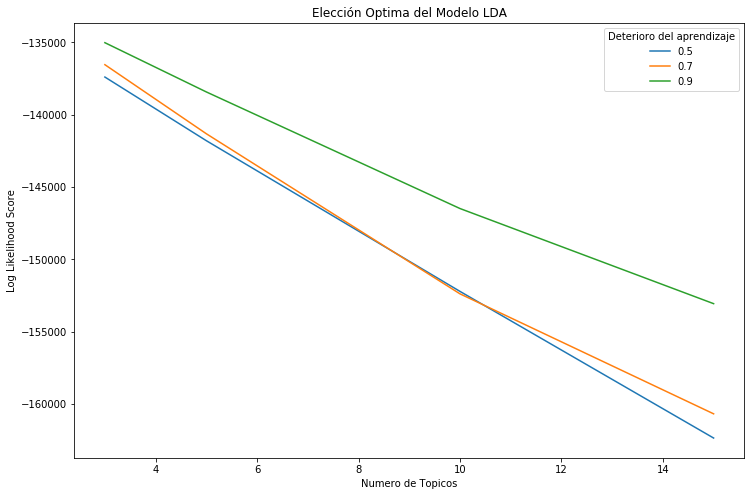

In [27]:
from matplotlib.pyplot import *
import matplotlib.pyplot as plt

# Get Log Likelyhoods from Grid Search Output
n_topics = [3, 5, 10, 15]
log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if (gscore.parameters['learning_decay']==0.5 and gscore.parameters['max_iter']==10)]
log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if (gscore.parameters['learning_decay']==0.7 and gscore.parameters['max_iter']==10)]
log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if (gscore.parameters['learning_decay']==0.9 and gscore.parameters['max_iter']==10)]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, np.array(log_likelyhoods_5), label='0.5')
plt.plot(n_topics, np.array(log_likelyhoods_7), label='0.7')
plt.plot(n_topics, np.array(log_likelyhoods_9), label='0.9')
plt.title("Elección Optima del Modelo LDA")
#plt.xlim(xmin=0.0, xmax=15)
plt.xlabel("Numero de Topicos")
plt.ylabel("Log Likelihood Score")
plt.legend(title='Deterioro del aprendizaje', loc='best')
plt.show()

**IV)- Identificación de Tópicos:** Para mostrar los tópicos, se definió una función que retorna las 30 palabras de cada tópico generados en el modelo LDA. Esta función recibe los siguientes parámetros:

* best_lda_model: El mejor modelo obtenido con GridSearchCV.
* tf_feature_names: Las características de la matriz de términos.
* n_top_words: El número de palabras por tópico.


In [28]:
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*90)

Los tópicos detectados se muestran a continuación:

In [29]:
n_top_words = 35
print("\nTopics in LDA model: ")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(best_lda_model, tf_feature_names, n_top_words)


Topics in LDA model: 

Topic #0:specified get account information group given fabric project item return retrieve specific resource node application report schedule detail product version operation existing associated update date template available file cluster deletes access player endpoint oauth container

Topic #1:subscription operation item entity retrieve version event preview revenue plan invoice tenant resume object azure account oauth billing network cancel period product resource adjustment accounting multi provides renew access microsoft test minor usage field production

Topic #2:invoice payment revenue credit schedule order field method charge account item version minor refund number cancel specify header entry journal parameter multi href accounting product information rate authentication target send following summary oauth suspend access


**Visualizacion de Topicos Dominantes por Documento:** Para clasificar un documento como perteneciente a un tópico en particular, el enfoque usado es ver qué tópico tiene la mayor contribución a ese documento y asignarlo. En la siguiente tabla se listan los primeros 20 documentos junto con la proporción de contribución a cada tópico. El tópico predominante (marcado con color rojo) se detalla aparte en su propia columna.

In [31]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np

# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ['Topic' + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ['Doc' + str(i) for i in range(len(new_data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['Topic_dom'] = dominant_topic

# Styling
def color_green(val):
    color = 'red' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(20).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic_dom
Doc0,0.4,0.03,0.57,2
Doc1,0.09,0.09,0.82,2
Doc2,0.89,0,0.11,0
Doc3,0.89,0.06,0.06,0
Doc4,0.26,0.01,0.73,2
Doc5,0.26,0.01,0.73,2
Doc6,0.26,0.01,0.73,2
Doc7,0.07,0.01,0.92,2
Doc8,0.07,0.01,0.92,2
Doc9,0.51,0.02,0.47,0


**Número de documentos por tópico:** Finalmente, haciendo una distribución cruzada de los datos se obtiene el número de documentos en los que aparece un determinado topico.

In [32]:
df_topic_distribution = df_document_topic['Topic_dom'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topico Num', 'Num Documentos']
df_topic_distribution

,Topico Num,Num Documentos
0,0,640
1,1,289
2,2,97


**Visualización del Tópico dominante:** Una forma de visualización muy común son las _Word Clouds_ (nube de palabras). Es una imagen compuesta por una combinación de palabras distintas que pueden constituir un texto y donde el tamaño de cada palabra es proporcional a la frecuencia de la palabra en ese texto. Como ejemplo, la siguiente figura muestra la word cloud para el tópico 0 (tópico dominante).

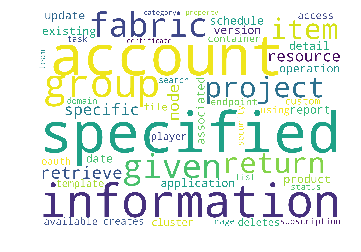

In [39]:
topico_dom = best_lda_model.components_[0]
topic_words = [tf_feature_names[i] for i in topico_dom.argsort()[:-50 - 1 :-1]]
#topico_dom.shape (NUMERO DE CARACTERISTICAS, ES IGUAL PARA TODOS LOS TOPICOS)

#NECESARIO INSTALAR VISUAL STUDIO

import os
from PIL import Image
import matplotlib.pyplot as plt
from setuptools import setup
from wordcloud import WordCloud

firstcloud = WordCloud(
                          background_color='white',
                          width=2500,
                          height=1800
                         ).generate(" ".join(topic_words))
plt.imshow(firstcloud)
plt.axis('off')
plt.show()